<a href="https://colab.research.google.com/github/mamikah/DeepLearning2022Late/blob/main/Selenium%E3%81%A7%E7%94%BB%E5%83%8F%E5%8F%8E%E9%9B%862022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# seleniumを使って自動で画像検索し、結果を収集する

## 必要なアプリのインストール
### Seleniumのインストール（バージョンを指定する）

In [ ]:
!pip install selenium==4.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### chronium-chromedriver のインストール

In [ ]:
!apt install chromium-chromedriver

Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (107.0.5304.87-0ubuntu11.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


## seleniumを実行して操作する

### その他のライブラリのimport

In [ ]:
import requests
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import os
import time
import datetime
# エラー処理用
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementClickInterceptedException

## ログ用に時刻を取得

In [ ]:
tm_start = time.time( ) # 処理時間計測用
dt_now = datetime.datetime.now( ) # 現在日時
dt_date_str = dt_now.strftime( '%Y/%m/%d %H:%M' ) # 書式指定して変換
print( dt_date_str )

2022/12/06 02:22


## 検索に関する設定値を定義する

In [ ]:
QUERY = '犬 フリー' # 検索したいキーワード
LIMIT_DL_NUM = 100 # ダウンロード数の上限
SAVE_DIR = 'img/dog_' # 出力フォルダ（自動生成させる）
FILE_NAME = 'dog_' # ファイル名（後ろに連番と拡張子をつけていく）
TIMEOUT = 60 # 検索のタイムアウト（秒）
ACCESS_WAIT = 1 # アクセスする間隔(秒)←超重要
RETRY_NUM = 3 # クリックやrequestのリトライ回数
DRIVER_PATH = '/usr/bin/chromedriver' # chromedriver.exeへのパス

## Chromeをヘッドレスモードで起動する

ヘッドレスモード = ブラウザを画面に開かないで実行するモード

In [ ]:
# optionの指定を準備
options = Options( )
options.add_argument( '--headless' )
options.add_argument(  '--no-sandbox'  )
options.add_argument(  '--disable-dev-shm-usage'  )
options.add_argument(  'start-fullscreen'  )
options.add_argument(  '--disable-plugins'  )
options.add_argument(  '--disable-extensions'  )
# 起動する
driver = webdriver.Chrome( DRIVER_PATH, options=options )
driver.implicitly_wait( TIMEOUT ) # タイムアウトを設定
# ログに処理時間を出力
tm_driver = time.time(  )
print( 'WebDriver起動完了', f'{tm_driver - tm_start:.1f}s' )

<ipython-input-20-42bd84c0394a>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome( DRIVER_PATH, options=options )


WebDriver起動完了 7.9s


## Googleの画像検索へアクセス

In [ ]:
# QUERY条件付きでURLを定義する
url = f'https://www.google.com/search?q={QUERY}&tbm=isch'
# 組み立てたURLでアクセスして検索
driver.get( url)
# 時刻のログを取得
tm_geturl = time.time( )
print( 'Google画像検索ページ取得', f'{tm_geturl - tm_driver:.1f}s' )


Google画像検索ページ取得 5.2s


## 検索結果の要素を取得していく

In [ ]:
# ページのサムネイル画像の要素群を取得
# (islmpクラスが指定されたimg=サムネイルをすべて拾う)
tmb_elems = driver.find_elements_by_css_selector('#islmp img')
# サムネイルのリストから各サムネイルのalt属性を取得していく
tmb_alts = [ tmb.get_attribute('alt') for tmb in tmb_elems ]
# alt属性が空（小さいサムネイル）のものを差し引いて合計を算出
count = len(tmb_alts) - tmb_alts.count('')
print(count)

<ipython-input-22-478ad0829502>:3: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  tmb_elems = driver.find_elements_by_css_selector('#islmp img')


48


## 下にスクロールさせてさらに検索結果を表示させてまたカウント

In [ ]:
# 定義したLIMIT_DL_NUM（ダウンロード数の上限）になるまでスクロールを繰り返す
while count < LIMIT_DL_NUM:
  # ページの一番下へスクロールして新しいサムネイル画像を表示させる
  driver.execute_script( 'window.scrollTo(0, document.body.scrollHeight);' )
  time.sleep( 1 ) # スリープを繰り返す間隔(秒)を入れる ←重要
  # (islmpクラスが指定されたimg=サムネイルをすべて拾う)
  tmb_elems = driver.find_elements_by_css_selector('#islmp img')
  # サムネイルのリストから各サムネイルのalt属性を取得していく
  tmb_alts = [ tmb.get_attribute('alt') for tmb in tmb_elems ]
  # alt属性が空（小さいサムネイル）のものを差し引いて合計を算出
  count = len(tmb_alts) - tmb_alts.count('')
  print(count)
# ループ終わり

<ipython-input-23-efe427a5e67b>:7: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  tmb_elems = driver.find_elements_by_css_selector('#islmp img')


100


## サムネイル画像をクリックすると右側に開かれる領域をオブジェクトに取得

In [ ]:
imgframe_elem = driver.find_element_by_id( ('islsp') )

<ipython-input-24-713e481369ea>:1: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  imgframe_elem = driver.find_element_by_id( ('islsp') )


### 画像へURLアクセスして保存する準備をする

In [ ]:
# 画像の保存フォルダを作成
os.makedirs( SAVE_DIR, exist_ok=True )
# HTTPリクエスト用のヘッダーを作る
HTTP_HEADERS = {'User-Aget':driver.execute_script('return navigator.userAgent;')}
print( HTTP_HEADERS )
# ダウンロードしてきたい対象のファイル拡張子(extensios)
IMG_EXTS = ( '.jpg', '.jpeg', '.png', '.gif' )

{'User-Aget': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/107.0.5304.87 Safari/537.36'}


## ダウンロード中に利用する関数を定義する
### 画像の拡張子を取得する関数

In [ ]:
# 拡張子を取得する関数
def get_extension( url ):
  url_lower = url.lower()
  for img_ext in IMG_EXTS: # 拡張子のリストから１つずつ比較
    if img_ext in url_lower:
      extension = '.jpg' if img_ext == '.jpeg' else img_ext
      break
    # if終わり
    else:
        extension = ''
  # for終わり
  return extension
# 関数終わり

### urlで指定した画像へアクセスし、フォルダ内のファイルとして書き込む

In [ ]:
def download_image(  url, path, loop ):
  result = False  # 戻り値の変数
  for i in range(loop):
    try:
      r = requests.get( url, headers=HTTP_HEADERS, stream=True, timeout=10 )
      r.raise_for_status( )
      with open ( path, 'wb' ) as f: # バイナリ書き込みモードで開く
        f.write( r.content )

    except requests.exceptions.SSLError:
      print('****** SSL エラー')
      break # リトライしない  
    except requests.exceptions.RequestException as e:
      print( f'***** requests エラー( {e} ): {i + 1}/{RETRY_NUM}' )
      time.sleep(1)
    else:
      result = True
      break # try成功
  # ループ終わり  
# 関数終わり

In [ ]:
### サムネイルを取得し、画像ダウンロードの準備ができたタイミング
tm_thumbnails = time.time( )
print( 'サムネイル画像取得とＤＬ準備完了', f'{tm_thumbnails - tm_geturl:.1f}s' )

サムネイル画像取得とＤＬ準備完了 38.8s


## ダウンロード処理

0:犬の写真素材｜写真素材なら「写真AC」無料（フリー）ダウンロードOK


/usr/local/lib/python3.8/dist-packages/selenium/webdriver/remote/webelement.py:484: UserWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  warnings.warn("find_element_by_* commands are deprecated. Please use find_element() instead")


1:犬 | フリー素材ドットコム
2:犬 | フリー素材ドットコム
***** urlに拡張子が含まれていないのでキャンセル

2:へっくしょん（犬）の写真素材 - ぱくたそ
3:犬の写真素材｜写真素材なら「写真AC」無料（フリー）ダウンロードOK
4:犬 のストック写真、ロイヤリティフリーの画像、ベクター、およびビデオ | Adobe Stock
5:犬の写真素材｜写真素材なら「写真AC」無料（フリー）ダウンロードOK
6:フリー写真] 芝生を駆ける二匹の子犬でアハ体験 - GAHAG | 著作権フリー写真・イラスト素材集
***** urlチェック:1/3
***** requests エラー( 403 Client Error: Forbidden for url: https://img01.gahag.net/201601/14o/gahag-0046037255.jpg ): 1/3
***** requests エラー( 403 Client Error: Forbidden for url: https://img01.gahag.net/201601/14o/gahag-0046037255.jpg ): 2/3
***** requests エラー( 403 Client Error: Forbidden for url: https://img01.gahag.net/201601/14o/gahag-0046037255.jpg ): 3/3
7:犬（戌）」をテーマにした無料写真素材10選（商用利用可） | ACワークスのブログ
8:無料で使える 犬 フリー素材 - 使える写真ギャラリーSothei
9:怠惰な秋田犬の写真素材 - ぱくたそ
10:画像素材なら！無料・フリー写真素材のフリーフォト
***** urlチェック:1/3
***** urlチェック:2/3
***** urlチェック:3/3
***** urlに拡張子が含まれていないのでキャンセル

10:犬 | フリー素材ドットコム
11:犬の写真素材｜写真素材なら「写真AC」無料（フリー）ダウンロードOK
12:フリー写真素材|動物|哺乳類|イヌ科|犬・イヌ|子犬・小犬|柴犬 ... | Dog blog, Shiba inu, Cute animals
13:フリー写真] 耳
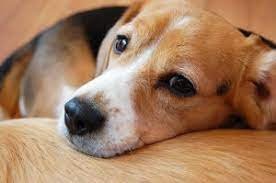
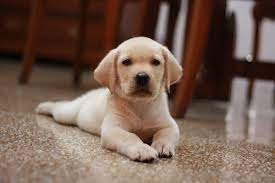
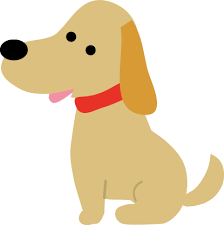
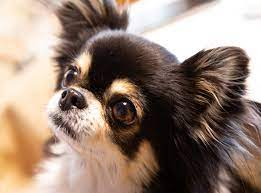

In [ ]:
EXCLUSION_URL = 'https//lh3.googleusercontent.com/' # 除外対象URL
count = 0
url_list = [ ]

# サムネイルをクリック、画像リンクを取得、画像をDL＆保存を繰り返す
# zipで組み合わせの順番を固定化
for tmb_elem, tmb_alt in zip(tmb_elems, tmb_alts): 
  if tmb_alt == '': # ALT属性が空=小さいサムネイルとみなしてスキップ
    continue  
  print(  f'{count}:{tmb_alt}'  ) # カウンタとALT属性を表示
  # リトライ回数分だけ試行
  for i in range(RETRY_NUM):
    # サムネイルをクリック
    try:
      tmb_elem.click( )
    except ElementClickInterceptedException:
      print(f'***** click エラー: {i+1}/{RETRY_NUM}')
      # フォーカスをあわせる
      driver.execute_script('arguments[0].scrollIntoView(true);', tmb_elem)
      time.sleep(1)
    else:
      break # try成功（クリック成功）
  # forの終わり
  else: 
    print('***** キャンセル')
    continue # リトライ失敗、次のアイコンにスキップ
  # クリック成功したら、処理を続ける（画像のオブジェクトを取得する処理）
  time.sleep(ACCESS_WAIT)
  # alt属性の加工
  alt = tmb_alt.replace("'","\\")
  try:
    # 左側のalt属性を基に左側の大きな画像をalt属性を指定して取得
    img_elem = imgframe_elem.find_element_by_css_selector(f'img[alt=\'{alt}\']')
  except NoSuchElementException:  # 右側に対応する要素が見つからない
    print('***** img要素検索エラー')
    print('***** キャンセル')
    continue # 次のサムネイルへスキップ
  # 右の大きな画像オブジェクトが取得できたら、その画像リンクを取得する

  tmb_url = tmb_elem.get_attribute('src')  # サムネイルsrc属性からリンクurlを取得
  # リトライしながらURLをチェック
  for i in range(RETRY_NUM):
    # 大きい画像のURL
    url = img_elem.get_attribute('src')
    if EXCLUSION_URL in url:
      print('除外対象url')
      url=''
      break # ループ中断
    elif url == tmb_url: # サムネイルのurlと一緒なら、リトライを続ける
      print(f'***** urlチェック:{i+1}/{RETRY_NUM}')
    else:
      break # ループ中断（除外対象でもサムネイルでもない、OKなurl）
    # RETRYループ終わり
  # urlチェックの結果、OKなリンクでなければ次のサムネイルへスキップ
  if url == '':
    print('***** キャンセル') # 大きなループをcontinue
    continue
  # url先の拡張子が指定の画像拡張子でなければ次のサムネイルへスキップ
  ext = get_extension( url ) # 自作の関数で拡張子を取得
  if ext == '': # 指定の画像拡張子でない場合
    print(f'***** urlに拡張子が含まれていないのでキャンセル')
    print(f'{url}')
    continue
  
  # ダウンロード周り:保存するファイルパスを指定する
  filename = f'{FILE_NAME}{count}{ext}'
  path = SAVE_DIR + '/' + filename
  # ダウンロードを実行（自作関数を呼び出す）
  result = download_image( url, path, RETRY_NUM )
  if result == False:
    print('***** キャンセル')
    continue # 次のサムネイルへスキップ
  # ダウンロードしたurlをリストに追加
  url_list.append(f'{filename}:{url}')

  # 最後に、ダウンロード数カウンタの更新と終了判定
  count += 1
  if count >= LIMIT_DL_NUM:
    break # ダウンロードのループを終了
# ループの終了
# 所領時間の表示
tm_end = time.time( ) # 現在時刻
print('ダウンロード', f'{tm_end - tm_thumbnails:.1f}s')
print('-------------------------')

## Colabo上へダウンロードしたファイルをipで固めてローカルにダウンロードする

In [ ]:
# ここまでのトータル所要時間を出力する
total = tm_end - tm_start
total_str = f'トータル時間:{total:.1f}s({total/60:.2f}min)'
count_str = f'ダウンロード数:{count}'
print(total_str)
print(count_str)

トータル時間:1559.6s(25.99min)
ダウンロード数:84
